Installing Fastai

In [ ]:
!pip install fastai -q --upgrade

     |████████████████████████████████| 194kB 9.7MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 


Importing Fastai

In [ ]:
import fastai

In [ ]:
from fastai import *
from fastai.vision import *

In [ ]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *

In [ ]:
np.random.seed(21)

In [ ]:
path = untar_data(URLs.PETS)

In [ ]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [ ]:
Path.cwd()

Path('/content')

In [ ]:
fnames = get_image_files(path/'images')

In [ ]:
pat = r'(.+)_\d+.jpg$'

Transformations to apply on Data

In [ ]:
batch_tfms = [*aug_transforms(size = 224, max_warp = 0), Normalize.from_stats(*imagenet_stats)]

In [ ]:
item_tfms = RandomResizedCrop(size = 460, min_scale = 0.75, ratio = (1.,1,))

In [ ]:
bs = 64

In [ ]:
dls = ImageDataLoaders.from_name_re(path = path, fnames = fnames, pat = pat, bs = bs)

In [ ]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock), get_items = get_image_files, 
                 splitter = RandomSplitter(), item_tfms = item_tfms, batch_tfms = batch_tfms,
                 get_y = RegexLabeller(pat = r'/([^/]+)_\d+.*'))

In [ ]:
path_im = path/'images'

In [ ]:
dls = pets.dataloaders(path_im, bs = bs)

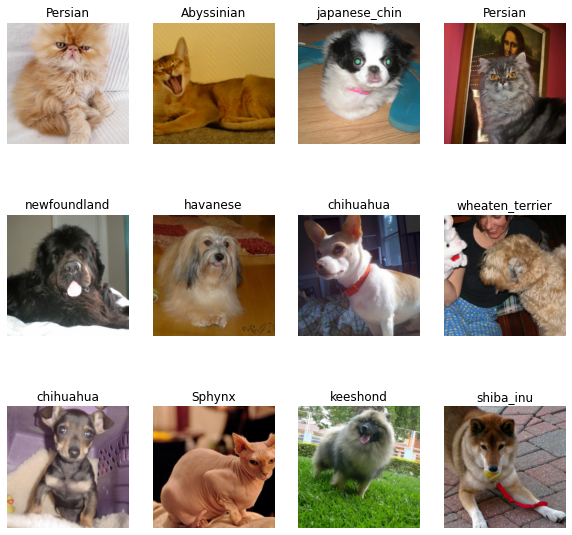

In [ ]:
dls.show_batch(max_n = 12, figsize = (10,10))

In [ ]:
dls.vocab

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

In [ ]:
dls.vocab.o2i

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

Creating a CNN Learner

In [ ]:
learn = cnn_learner(dls, arch= resnet34, pretrained= True, metrics=error_rate).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Fitting a model using Fit_one_cycle_method

In [ ]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,2.111395,0.422449,0.126522,01:03
1,0.720418,0.299131,0.094046,01:02
2,0.401978,0.283078,0.082544,01:02
3,0.284407,0.257992,0.079161,01:02
4,0.231682,0.255479,0.074425,01:02


Saving the model to disk

In [ ]:
learn.save('stage_1')

Path('models/stage_1.pth')

Interpretation of the results

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
losses, idxs = interp.top_losses()

In [ ]:
len(losses)==len(dls.valid_ds)

True

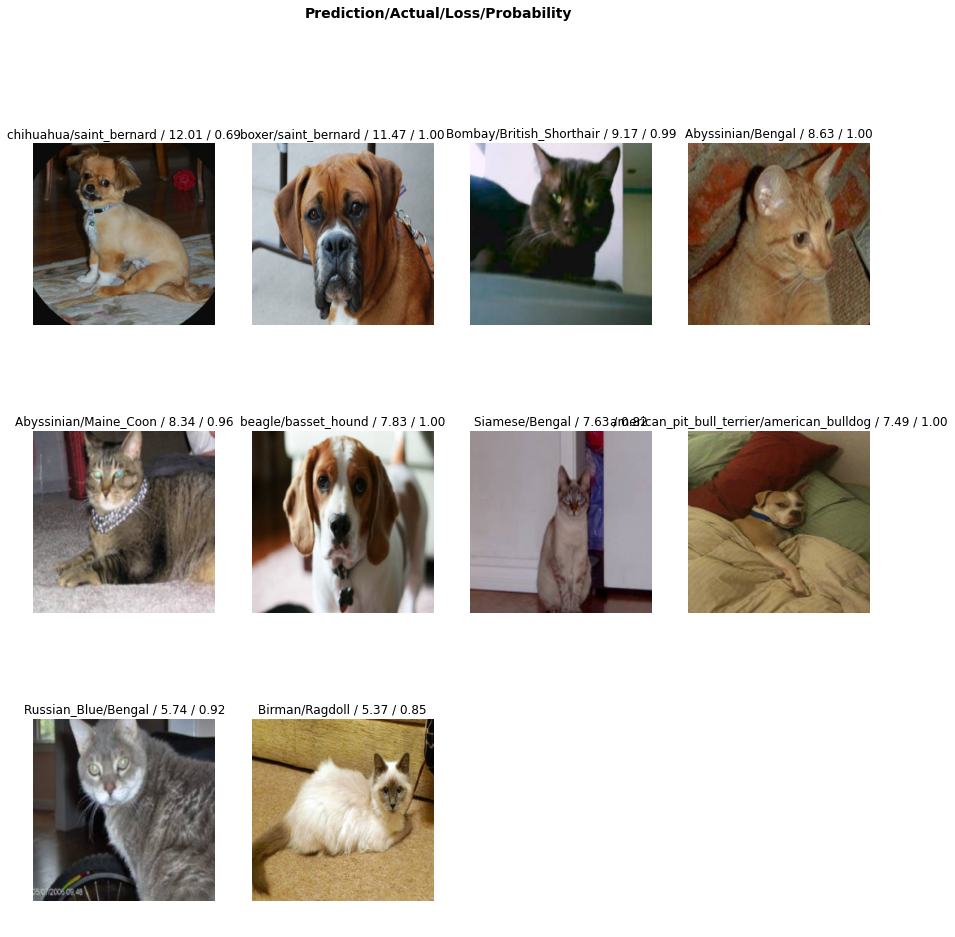

In [ ]:
interp.plot_top_losses(10,figsize=(15,15))

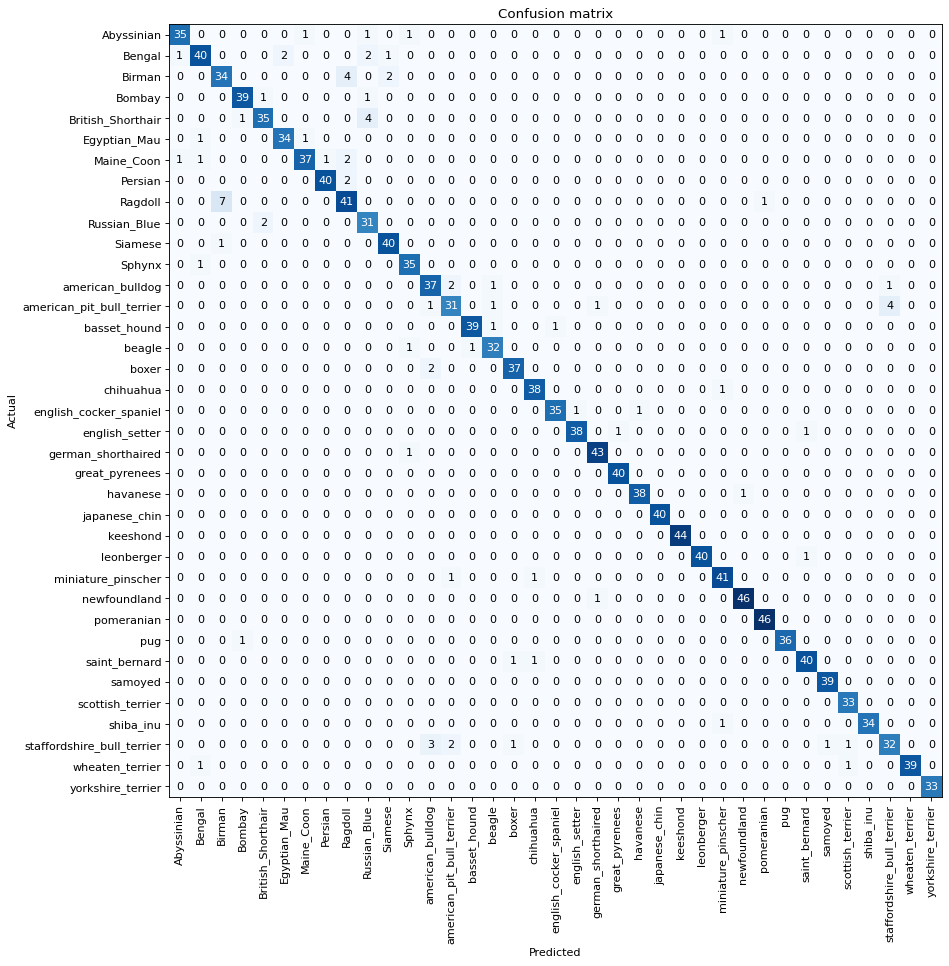

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=80)

In [ ]:
interp.most_confused(min_val= 4)

[('Ragdoll', 'Birman', 7),
 ('Birman', 'Ragdoll', 4),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4)]

In [ ]:
learn.load('stage_1')

Unfreezing the first layers of the model for further training

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.974860,3.916125,0.686062,01:06
1,1.136979,1.625273,0.447903,01:05
2,0.760671,0.947803,0.284844,01:03
3,0.399190,0.468216,0.146820,01:04
4,0.214163,0.420505,0.131258,01:04


In [ ]:
learn.load('stage_1')

Using Learning Rate Finder to find good Learing Rate

SuggestedLRs(valley=3.981071586167673e-06)

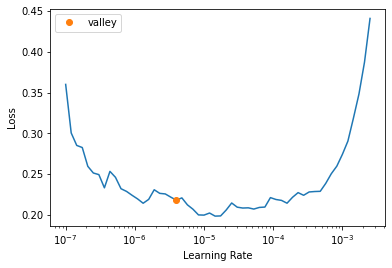

In [ ]:
learn.lr_find()

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, lr_max= slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.210027,0.243366,0.077808,01:05
1,0.197792,0.240336,0.074425,01:03
2,0.175604,0.235588,0.069689,01:04
3,0.156647,0.229279,0.063599,01:04
4,0.141284,0.229939,0.065629,01:03


In [ ]:
learn.save('stage_2')

Path('models/stage_2.pth')

In [ ]:
learn1 = cnn_learner(dls, resnet50, pretrained=True, metrics = error_rate).to_fp16()

SuggestedLRs(valley=0.0005754399462603033)

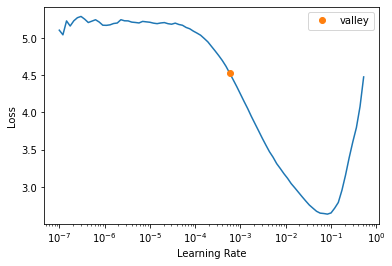

In [ ]:
learn1.lr_find()

In [ ]:
learn1.fit_one_cycle(5,lr_max=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,1.217407,0.335189,0.102165,01:08
1,0.499693,0.279385,0.084574,01:07
2,0.280237,0.252642,0.073072,01:07
3,0.185963,0.232945,0.071719,01:07
4,0.131687,0.227974,0.070365,01:08


In [ ]:
learn1.save('resnet50')

Path('models/resnet50.pth')